## Finding Blocks: Iterative extracction

In [1]:
############################################ Loading libraries and user arguments ###########################################

import os
from utils.blast_utils import unnoise_coords, makeblast_db, blastn, alignment_absolute_start_end, select_internal_aligns, retrieve_single_alignments
import pandas as pd
import matplotlib.pyplot as plt
import argparse
from Bio import SeqIO  

test = True
if test:
    print('Warning! Developer mode activated')
    input_fasta = '/home/jpereira/OEs/Results/OE1/ToxoPasteur1/Data/mcl_clustering/sequneces_clusters/cluster_1.fasta'
    input_fasta = '/home/jpereira/OEs/Results/OE1/NamSeqs//Data/mcl_clustering/sequneces_clusters/cluster_1.fasta'
    #input_fasta = '/home/jpereira/OEs/Results/OE1/NamSeqs/Data/Block_extension/blocks.fasta'

    #input_inner_fasta_tsv = '/home/jpereira/OEs/Results/OE1/ToxoPasteur1/Data/blast_to_abc/blastn.cluster1.inner.tsv'
    param_min_instances = 0
    param_threads = 90
    output_reciprocal_blast_tsv = '/home/jpereira/OEs/Results/OE1/ToxoPasteur1/Data/Blocks/blastn.infasta_reciprocal.tsv'
    output_coords_bed = '/home/jpereira/OEs/Results/OE1/ToxoPasteur1/Data/Blocks/regions.bed'
    output_blocks_fasta =  "/home/jpereira/OEs/Results/OE1/ToxoPasteur1/Data/Blocks/blocks.fasta"
    output_blocks_fasta =  "/home/jpereira/OEs/Results/OE1/NamSeqs/Data/Blocks_post_extend/block_post_extend.fasta"
    
    params_cluster_identity = 0.95
    params_cluster_coverage = 0.95
    params_select_internals_alns = True
    
    params_retrive_all = False
    
    
    print('Warning! Developer mode activated')
    #input_fasta = '/home/jpereira/OEs/Results/OE1/NamSeqs/Data/mcl_clustering/sequneces_clusters/cluster_1.fasta'
    ##input_inner_fasta_tsv = '/home/jpereira/OEs/Results/OE1/NamSeqs/Data/blast_to_abc/blastn.cluster1.inner.tsv'
    #param_min_instances = 5
    #param_threads = 90
    #output_reciprocal_blast_tsv = '/home/jpereira/OEs/Results/OE1/NamSeqs/Data/Blocks/blastn.infasta_reciprocal.tsv'
    #output_coords_bed = '/home/jpereira/OEs/Results/OE1/NamSeqs/Data/Blocks/regions.bed'
    #output_blocks_fasta =  "/home/jpereira/OEs/Results/OE1/NamSeqs/Data/Blocks/blocks.fasta"

else:
    parser = argparse.ArgumentParser()
    parser.add_argument('--input-fasta')
    parser.add_argument('--input-clust-names', type=float, default=95)
    parser.add_argument('--input-inner-fasta-tsv', type=int, default=50)
    parser.add_argument('--param-threads', type=int, default=20)
    parser.add_argument('--output-blocks-fasta')
    
    # Capture the parsed arguments in a variable (args)
    args = parser.parse_args()
    
    input_fasta = args.input_fasta
    input_inner_fasta_tsv = args.input_inner_fasta_tsv
    param_threads = args.param_threads
    output_blocks_fasta = args.output_blocks_fasta

##### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

Warning! Developer mode activated
Warning! Developer mode activated


In [31]:
############################################ Preparing sequences for iterative block finding ###########################################
infasta_db_dir = os.path.join(os.path.dirname(output_reciprocal_blast_tsv), 'blast_db', 'infasta_db') #'/home/jpereira/OEs/OE1.v2/Data/blocks/blast_db/infasta_db' 
os.makedirs(infasta_db_dir, exist_ok=True)

## Make a reciprocal blast using blastn function from blast utils
infasta_db = makeblast_db(seqs_path=input_fasta, db_out=infasta_db_dir, remove_old_db=True)
blastn(blast_input_seqs=input_fasta, blast_db_file=infasta_db, blast_output_table_tsv=output_reciprocal_blast_tsv,
             num_threads=100, reward=2, gap_extend=2, gapopen=4, penalty=-2, word_size=11)




Building a new DB, current time: 06/18/2025 15:15:14
New DB name:   /home/jpereira/OEs/Results/OE1/ToxoPasteur1/Data/Blocks/blast_db/infasta_db/blocks.fasta
New DB title:  /home/jpereira/OEs/Results/OE1/NamSeqs/Data/Block_extension/blocks.fasta
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 3000000000B
Adding sequences from FASTA; added 18 sequences in 0.000657082 seconds.


makeblastdb ran successfully.
Running: blastn -query /home/jpereira/OEs/Results/OE1/NamSeqs/Data/Block_extension/blocks.fasta -db /home/jpereira/OEs/Results/OE1/ToxoPasteur1/Data/Blocks/blast_db/infasta_db/blocks.fasta -out /home/jpereira/OEs/Results/OE1/ToxoPasteur1/Data/Blocks/blastn.infasta_reciprocal.tsv -num_threads 100 -reward 2 -gapextend 2 -gapopen 4 -penalty -2 -word_size 11 -outfmt '6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen'
blastn ran successfully.


In [ ]:
blast_df = pd.read_csv(output_reciprocal_blast_tsv, sep='\t')
blast_df.columns = ['qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen', 
                    'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore', 'qlen', 'slen']

blast_size = blast_df.shape[0]
print(f'Org_size: {blast_size}')
s0_df = blast_df[blast_df['pident'] > 90]
print(f'Filtered pident 90%: {s0_df.shape[0]/blast_size}')
s1_df = alignment_absolute_start_end(s0_df)
s2_df = select_internal_aligns(df=s1_df,border=20) 

# Filter by query alignment interval
if select_internal_aligns:
    s3_df = s2_df# blast.fuse_contained_intervals(df=s2_df, start_col='qstart', end_col='qend', group_cols=['qseqid', 'sseqid'], keep_highest_score_col='bitscore')
else:
    s3_df = s1_df

##### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Org_size: 138
Filtered pident 90%: 0.9420289855072463


Iteration dir: /home/jpereira/OEs/Results/OE1/NamSeqs/Data/Blocks_post_extend/block_iterations
Removieng previous iteration dir

###### ITERATION 0 ######



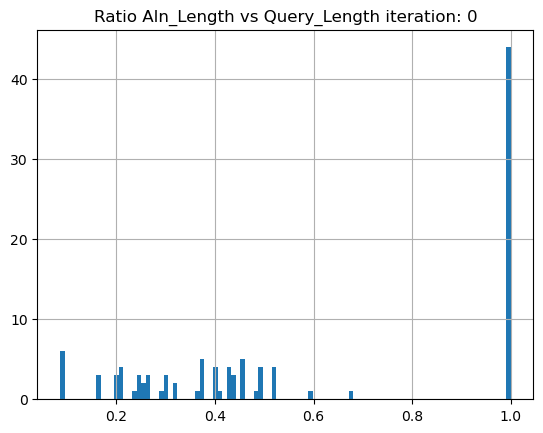

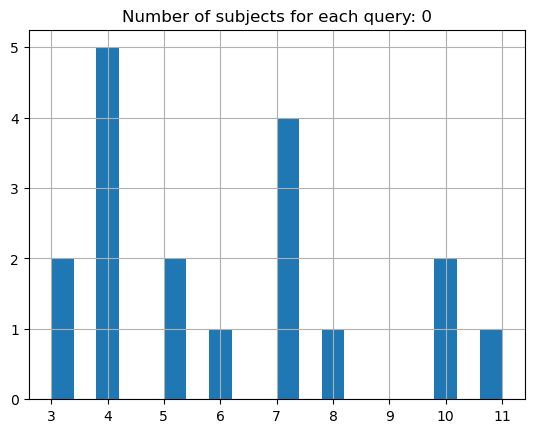

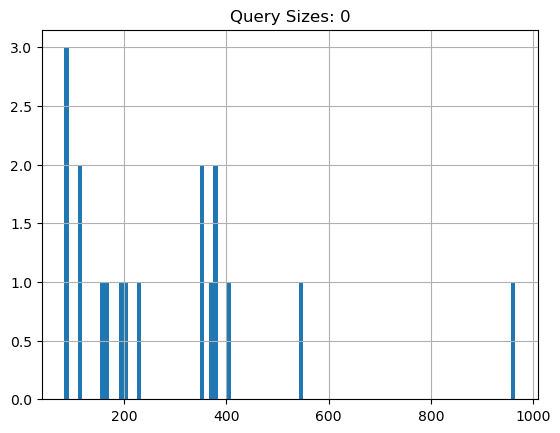

Running: bedtools getfasta -fi /home/jpereira/OEs/Results/OE1/NamSeqs/Data/Block_extension/blocks.fasta -bed /home/jpereira/OEs/Results/OE1/NamSeqs/Data/Blocks_post_extend/block_iterations/1/regions.bed -fo /home/jpereira/OEs/Results/OE1/NamSeqs/Data/Blocks_post_extend/block_iterations/1/regions.fasta
Executing command: vsearch --derep_fulllength /home/jpereira/OEs/Results/OE1/NamSeqs/Data/Blocks_post_extend/block_iterations/1/regions.fasta --output /home/jpereira/OEs/Results/OE1/NamSeqs/Data/Blocks_post_extend/block_iterations/1/derep.fasta --sizeout --relabel Seq --minseqlength 32
Executing command: vsearch --sortbysize /home/jpereira/OEs/Results/OE1/NamSeqs/Data/Blocks_post_extend/block_iterations/1/derep.fasta --output /home/jpereira/OEs/Results/OE1/NamSeqs/Data/Blocks_post_extend/block_iterations/1/sorted.fasta
Executing command: vsearch --cluster_size /home/jpereira/OEs/Results/OE1/NamSeqs/Data/Blocks_post_extend/block_iterations/1/sorted.fasta --id 0.9 --query_cov 0.9 --target_c

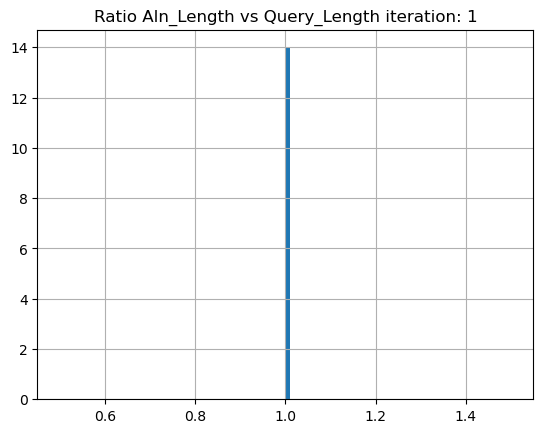

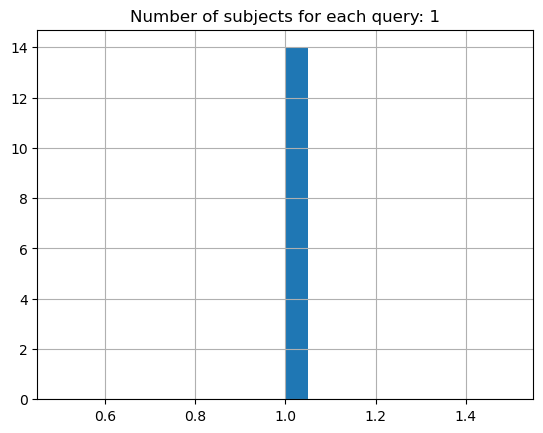

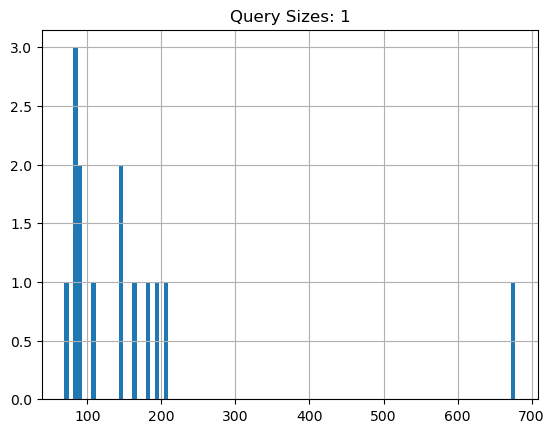

Retrieving sequences iteration: 1


,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,qlen,slen
0,Seq2;size=3,Seq2;size=3,100.0,161,0,0,1,161,1,161,1.570000e-72,256.0,161,161
2,Seq10;size=2,Seq10;size=2,100.0,196,0,0,1,196,1,196,3.860000e-89,312.0,196,196
4,Seq11;size=2,Seq11;size=2,100.0,90,0,0,1,90,1,90,6.060000e-39,144.0,90,90
6,Seq12;size=2,Seq12;size=2,100.0,82,0,0,1,82,1,82,3.540000e-35,131.0,82,82
9,Seq3;size=2,Seq3;size=2,100.0,205,0,0,1,205,1,205,2.060000e-93,326.0,205,205
13,Seq4;size=2,Seq4;size=2,100.0,183,0,0,1,183,1,183,5.700000e-83,291.0,183,183
16,Seq9;size=2,Seq9;size=2,100.0,69,0,0,1,69,1,69,4.520000e-29,110.0,69,69
18,Seq13;size=1,Seq13;size=1,100.0,109,0,0,1,109,1,109,6.460000e-48,174.0,109,109
20,Seq14;size=1,Seq14;size=1,100.0,83,0,0,1,83,1,83,1.200000e-35,133.0,83,83
23,Seq16;size=1,Seq16;size=1,100.0,86,0,0,1,86,1,86,4.640000e-37,137.0,86,86


Running: bedtools getfasta -fi /home/jpereira/OEs/Results/OE1/NamSeqs/Data/Blocks_post_extend/block_iterations/1/centroids.fasta -bed /home/jpereira/OEs/Results/OE1/NamSeqs/Data/Blocks_post_extend/block_iterations/1/retrieve/regions.bed -fo /home/jpereira/OEs/Results/OE1/NamSeqs/Data/Blocks_post_extend/block_iterations/1/retrieve/regions.fasta
Descomposition finished, all blocks are independent


In [61]:
############################################ Iterative Block finding ###########################################

import warnings
warnings.filterwarnings('ignore')

import shutil
import pandas as pd
from utils.bedtools_utils import bedtools_getfasta, coords_to_regions, blast_to_bed
from utils.vsearch_utils import vsearch_dereplication, vsearch_clustersize, vsearch_sortbysize


iteration_dir = os.path.join(os.path.dirname(output_blocks_fasta), 'block_iterations')
print(f"Iteration dir: {iteration_dir}")
if os.path.isdir(iteration_dir): 
    print("Removieng previous iteration dir")
    shutil.rmtree(iteration_dir)
os.makedirs(iteration_dir, exist_ok=True)
iteration = 0
num_blocks = []
while iteration <= 1:
    
    iteration += 1
    print(f"\n###### ITERATION {iteration - 1 } ######\n")

    in_fasta                         = os.path.join(iteration_dir, f'{iteration - 1}', 'centroids.fasta')
    blast_db                         = os.path.join(iteration_dir, f'{iteration}', 'blast_db')
    reciprocal_blast_tsv             = os.path.join(iteration_dir, f'{iteration}', 'blastn.reciprocal.tsv')
    coords_bed                       = os.path.join(iteration_dir, f'{iteration}', 'regions.bed')
    extracted_regions_fasta          = os.path.join(iteration_dir, f'{iteration}', 'regions.fasta')
    retrieve_coords_bed              = os.path.join(iteration_dir, f'{iteration-1}', 'retrieve', 'regions.bed')
    retrieve_extracted_regions_fasta = os.path.join(iteration_dir, f'{iteration-1}', 'retrieve', 'regions.fasta')
    derep_fasta                      = os.path.join(iteration_dir, f'{iteration}', 'derep.fasta')
    sorted_fasta                     = os.path.join(iteration_dir, f'{iteration}', 'sorted.fasta')
    centroids_fasta                  = os.path.join(iteration_dir, f'{iteration}', 'centroids.fasta')
    clusters_uc                      = os.path.join(iteration_dir, f'{iteration}', 'clusters.uc')
    
    iteration_path = os.path.dirname(clusters_uc)
    iteration_log =  os.path.join(iteration_path, 'logs')
    os.makedirs(os.path.dirname(clusters_uc), exist_ok=True)
    os.makedirs(os.path.dirname(retrieve_coords_bed), exist_ok=True)
    
    ## Make a reciprocal blast using blastn function from blast utils
    if iteration == 1:
        blast_df = s0_df
        in_fasta = input_fasta
    else:
        blast_db = makeblast_db(seqs_path=in_fasta, db_out=blast_db, remove_old_db=True, log_file=iteration_log)
        
        blastn(blast_input_seqs=in_fasta,
               blast_db_file=blast_db,
               blast_output_table_tsv=reciprocal_blast_tsv,
               num_threads=80, reward=1, gap_extend=5, gapopen=5,
               penalty=-1, word_size=10, log_file=iteration_log)
        
        blast_df = pd.read_csv(reciprocal_blast_tsv, sep='\t')
        blast_df.columns = ['qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen', 
                    'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore', 'qlen', 'slen']


    blast_df = blast_df[blast_df['pident'] > 90]
    blast_df = blast_df[blast_df['length'] > 20]
    
    # Nueva búsqueda recursiva?
    # Evitar la obtencion de fragmentos con inserciones
    # Búsqueda de fragmentos con deleciones en los extremos, y luego expansión hasta que baje la identidad
    # Inlcuir coordenadas con bajas instancias? 

    #Block alignment size vs block size
    (blast_df['length']/blast_df['qlen']).hist( bins=100)
    plt.title(f"Ratio Aln_Length vs Query_Length iteration: {iteration-1}")
    plt.show()

    # Number of aligments for each block
    blast_df.groupby('qseqid')['sseqid'].count().hist(bins=20)
    plt.title(f"Number of subjects for each query: {iteration-1}")
    plt.show()
    

    blast_df.groupby('qseqid')['qlen'].first().hist(bins=100)
    plt.title(f"Query Sizes: {iteration - 1}")
    plt.show()

    num_blocks.append(blast_df['qseqid'].unique().shape[0])
    
    # Retrive aligmentes that only map with itself
    retrive_df, blast_df = retrieve_single_alignments(blast_df)
    if retrive_df.shape[0] != 0:
        print(f"Retrieving sequences iteration: {iteration -1}")
        display(retrive_df)
        retrive_bed_df = blast_to_bed(retrive_df)
        retrive_bed_df.to_csv(retrieve_coords_bed, sep='\t', header=False, index=False)
        bedtools_getfasta(fasta_path=in_fasta, bed_path=retrieve_coords_bed, extracted_regions_path=retrieve_extracted_regions_fasta, show_command=True, log_file=iteration_log)
    
    if blast_df.empty:
        print("Descomposition finished, all blocks are independent")
        break
        
    
    unnoised_df = blast_df.groupby('qseqid').apply(lambda x: unnoise_coords(x, radious=15))
    unnoised_df = unnoised_df.reset_index().drop(columns='level_1')

    # Filter coordinates with low number of instances 
    unnoised_df = unnoised_df[unnoised_df['instances'] > param_min_instances]

    # Apply the function across groups
    get_fasta_df = unnoised_df.groupby('qseqid', group_keys=False).apply(coords_to_regions)
    get_fasta_df.to_csv(coords_bed, sep='\t', header=False, index=False)
    bedtools_getfasta(fasta_path=in_fasta, bed_path=coords_bed, extracted_regions_path=extracted_regions_fasta, show_command=True, log_file=iteration_log)
    vsearch_dereplication(input_fasta=extracted_regions_fasta, derep_fasta=derep_fasta, min_seq_length=32, log_file=iteration_log)
    vsearch_sortbysize(derep_fasta=derep_fasta, sorted_fasta=sorted_fasta, log_file=iteration_log)
    vsearch_clustersize( sorted_fasta=sorted_fasta, centroids_fasta=centroids_fasta, uc_file=clusters_uc,query_cov=0.90,
                        target_cov=0.90, id_thresh=0.90, min_seq_length=32, log_file=iteration_log,
                        use_both_strands=True,use_sizein=True)
    print(iteration)
##### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   

In [62]:
retrive_bed_df


,qseqid,qstart,qend
0,Seq2;size=3,1,161
2,Seq10;size=2,1,196
4,Seq11;size=2,1,90
6,Seq12;size=2,1,82
9,Seq3;size=2,1,205
13,Seq4;size=2,1,183
16,Seq9;size=2,1,69
18,Seq13;size=1,1,109
20,Seq14;size=1,1,83
23,Seq16;size=1,1,86


In [44]:
unnoised_df.size
get_fasta_df

,id,start,end
0,block_1,1,83
0,block_10,1,112
0,block_11,1,206
1,block_11,206,367
0,block_12,1,184
1,block_12,184,380
0,block_13,3,91
1,block_13,91,200
0,block_14,1,184
1,block_14,184,380


In [20]:
# Retrive aligmentes that only map with itself
retrive_df

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,qlen,slen
5296,Seq589;size=3,Seq589;size=3,100.0,32,0,0,1,32,1,32,2.700000e-13,62.2,32,32
6221,Seq760;size=2,Seq760;size=2,100.0,35,0,0,1,35,1,35,5.700000e-15,68.0,35,35
6257,Seq780;size=2,Seq780;size=2,100.0,32,0,0,1,32,1,32,2.700000e-13,62.2,32,32
7604,Seq1052;size=1,Seq1052;size=1,100.0,45,0,0,1,45,1,45,1.330000e-20,87.2,45,45
7632,Seq1055;size=1,Seq1055;size=1,100.0,36,0,0,1,36,1,36,1.570000e-15,69.9,36,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23763,Seq4817;size=1,Seq4817;size=1,100.0,32,0,0,1,32,1,32,2.700000e-13,62.2,32,32
23839,Seq4828;size=1,Seq4828;size=1,100.0,33,0,0,1,33,1,33,7.480000e-14,64.1,33,33
23850,Seq4830;size=1,Seq4830;size=1,100.0,34,0,0,1,34,1,34,2.070000e-14,66.1,34,34
23885,Seq4854;size=1,Seq4854;size=1,100.0,58,0,0,1,58,1,58,5.550000e-28,112.0,58,58


In [98]:
print(len(blast_df['qseqid'].unique()))

print(len(blast_df[blast_df['qseqid'] != blast_df['sseqid'] ]['qseqid'].unique()))

1816
1597


<Axes: >

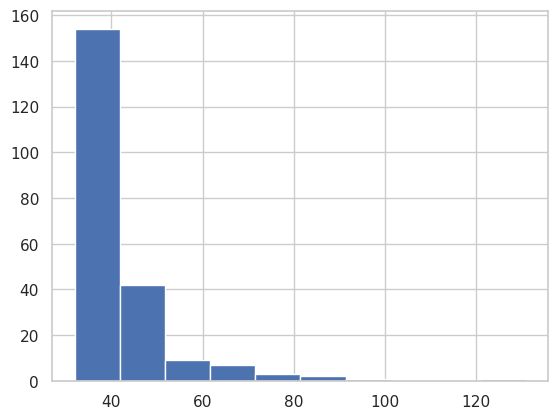

In [102]:
# Select queries that align with a different subject than itself
query_list = blast_df[(blast_df['qseqid'] != blast_df['sseqid']) ]['qseqid'].unique()

#Discard queries that have an aligment with a different subject than itself
mask = blast_df['qseqid'].isin(query_list)
single_map_df = blast_df[~mask]
single_map_df['qlen'].hist()


## Block recontruction: Extending MSA consensus

In [ ]:
from collections import Counter

def consensus_sequence(seqs: list[str]) -> str:
    """
    Given a list of equal-length strings (seqs), return the consensus
    by picking the most frequent character at each position.
    """
    # Check that all sequences are the same length
    length = len(seqs[0])
    if any(len(s) != length for s in seqs):
        raise ValueError("All sequences must be the same length")

    # Build consensus by iterating over columns
    consensus = []
    for column in zip(*seqs):
        # column is a tuple like ('A','A','G','A',...)
        most_common, _ = Counter(column).most_common(1)[0]
        consensus.append(most_common)
    return "".join(consensus)

# Example usage:
sequences = [
    "ATGCAA",
    "ATGGAT",
    "ATGCAT",
    "ATGTAT",
]
print(consensus_sequence(sequences))  # → "ATGCA"


ATGCAT


In [128]:
from collections import Counter
import math

def shannon_entropy(column):
    """Calculate Shannon entropy for a list of bases in a column."""
    counts = Counter(column)
    total = sum(counts.values())
    entropy = 0.0
    for base, count in counts.items():
        p = count / total
        entropy -= p * math.log2(p)
    return entropy

def compute_column_entropies(seqs):
    """Compute entropy of each column in an MSA (list of equal-length strings)."""
    if any(len(s) != len(seqs[0]) for s in seqs):
        raise ValueError("All sequences must be the same length")

    entropies = []
    for i, column in enumerate(zip(*seqs)):
        e = shannon_entropy(column)
        entropies.append(e)
        #print(f"Column {i+1}: {column} -> Entropy = {e:.3f}")
    return entropies

entropies = compute_column_entropies(sequences)


In [125]:
import random

def generate_random_sequences(n, length, freqs=None):
    """
    Generate N random DNA sequences of a given length,
    using specified nucleotide frequencies.

    Parameters:
    - n (int): number of sequences
    - length (int): length of each sequence
    - freqs (dict): nucleotide frequencies, e.g. {"A": 0.3, "T": 0.3, "C": 0.2, "G": 0.2}
                    If None, equal frequencies are used.

    Returns:
    - List of strings, each representing a DNA sequence.
    """

    bases = ["A", "T", "C", "G"]
    
    if freqs is None:
        # Default: uniform distribution
        probs = [0.25] * 4
    else:
        # Validate frequencies
        if not set(freqs.keys()).issubset(set(bases)):
            raise ValueError("Frequencies must be specified only for A, T, C, and G.")
        if abs(sum(freqs.values()) - 1.0) > 1e-6:
            raise ValueError("Frequencies must sum to 1.0")
        probs = [freqs.get(base, 0.0) for base in bases]

    sequences = []
    for _ in range(n):
        seq = "".join(random.choices(bases, weights=probs, k=length))
        sequences.append(seq)

    return sequences

In [129]:
import random

def mutate_sequence(original_seq: str, n: int, identity: float) -> list[str]:
    """
    Generate N mutated versions of an input sequence, with expected identity X.

    Parameters:
    - original_seq (str): reference DNA sequence (only A, T, C, G)
    - n (int): number of mutated sequences to generate
    - identity (float): expected identity (between 0 and 1)

    Returns:
    - List of mutated sequences
    """
    if not (0 <= identity <= 1):
        raise ValueError("Identity must be between 0 and 1.")

    valid_bases = ["A", "T", "C", "G"]
    original_seq = original_seq.upper()

    if not all(base in valid_bases for base in original_seq):
        raise ValueError("Input sequence must contain only A, T, C, G.")

    mutated_seqs = []
    mutation_rate = 1 - identity

    for _ in range(n):
        mutated = []
        for base in original_seq:
            if random.random() < mutation_rate:
                # Mutate: choose a different base
                other_bases = [b for b in valid_bases if b != base]
                mutated_base = random.choice(other_bases)
                mutated.append(mutated_base)
            else:
                mutated.append(base)
        mutated_seqs.append("".join(mutated))

    return mutated_seqs



(-0.05068788391464057, 2.1)

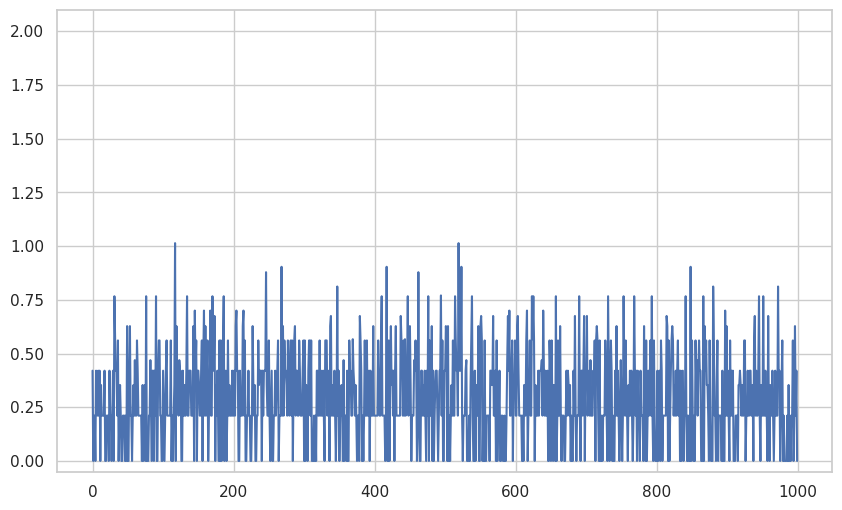

In [158]:
seq = generate_random_sequences(1, 1000)[0]
mutations_list = mutate_sequence(seq, 30, 0.95)
entropies = compute_column_entropies(mutations_list)

import numpy as np
plt.figure(figsize=(10,6))
plt.plot(entropies)
plt.ylim(top=2.1)


(0.0, 2.1)

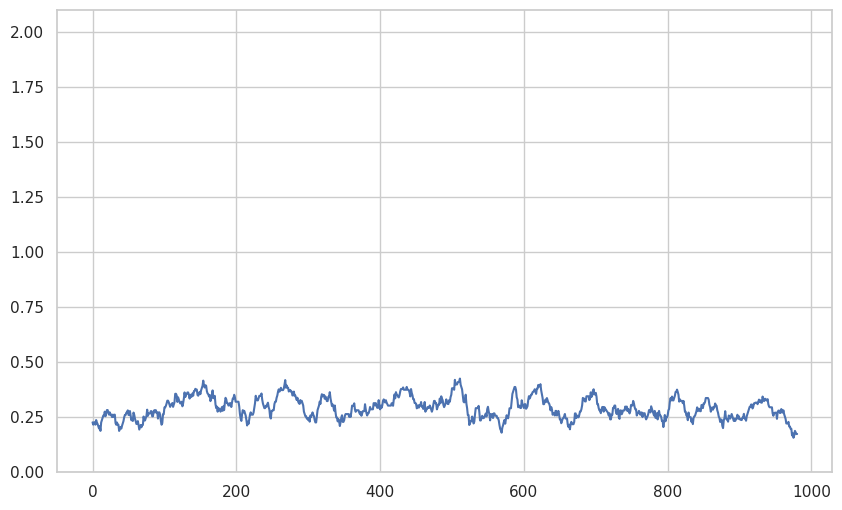

In [172]:
def sliding_window_mean(arr: list[float], window_size: int) -> list[float]:
    """
    Computes the mean of each sliding window of size `window_size` across the input list.

    Parameters:
    - arr (list of float/int): the input array
    - window_size (int): the size of the sliding window

    Returns:
    - list of float: mean values for each window
    """
    if window_size <= 0:
        raise ValueError("Window size must be a positive integer.")
    if window_size > len(arr):
        raise ValueError("Window size cannot be larger than the array length.")
    
    means = []
    for i in range(len(arr) - window_size + 1):
        window = arr[i:i + window_size]
        window_mean = sum(window) / window_size
        means.append(window_mean)
    
    return means

import numpy as np
plt.figure(figsize=(10,6))
plt.plot(sliding_window_mean(entropies, 20))
plt.ylim(top=2.1, bottom=0)



Text(0.5, 0, 'Iteration')

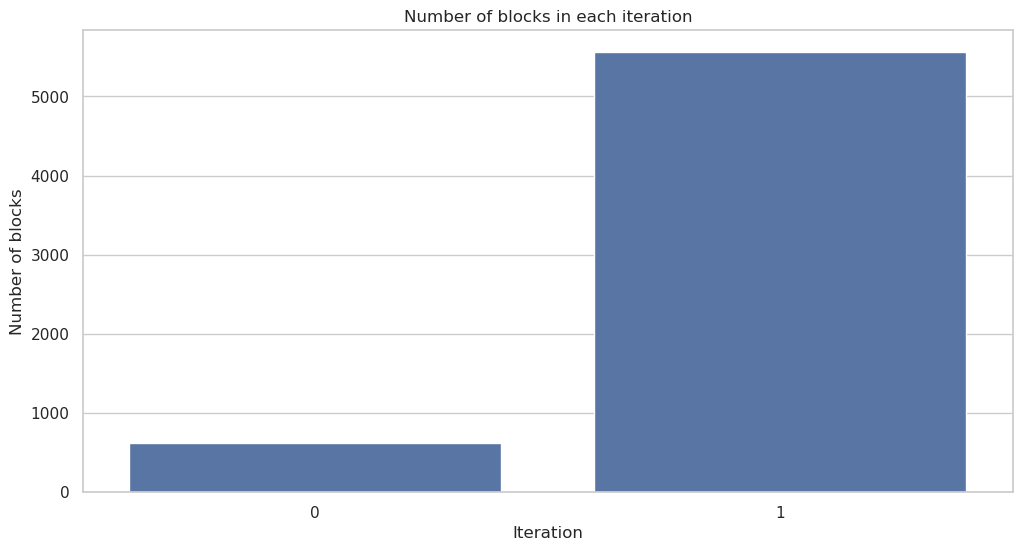

In [71]:
import seaborn as sns 
import numpy as np

sns.set_theme(style='whitegrid')

x_axis = [ q for q in range(len(num_blocks))]
plt.figure(figsize=(12,6))
sns.barplot(x=x_axis, y=num_blocks)
plt.title('Number of blocks in each iteration')
plt.ylabel('Number of blocks')
plt.xlabel('Iteration')

# Visualize reciprocal block coverage

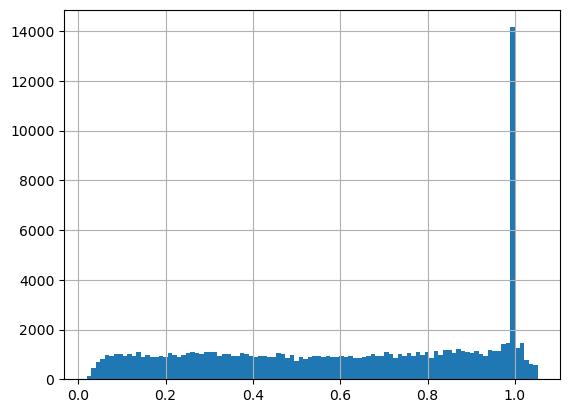

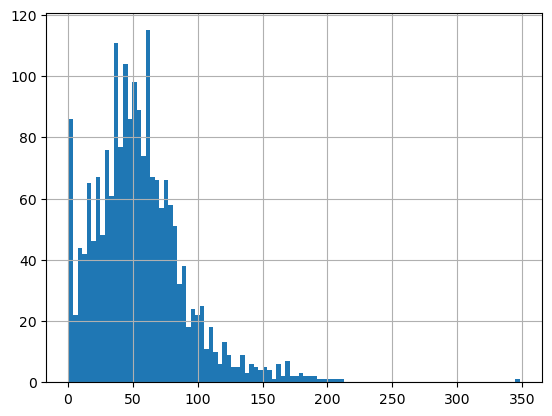

In [83]:
blast_df = pd.read_csv(blast_output_tsv, sep='\t')
blast_df.columns = ['qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen', 
                    'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore', 'qlen', 'slen']

blast_df = blast_df[blast_df['pident'] > 95]
# Nueva búsqueda recursiva?
# Evitar la obtencion de fragmentos con inserciones
# Búsqueda de fragmentos con deleciones en los extremos, y luego expansión hasta que baje la identidad
# Inlcuir coordenadas con bajas instancias? 

#Block alignment size vs block size
(blast_df['length']/blast_df['qlen']).hist( bins=100)
plt.show()

# Number of aligments for each block
blast_df.groupby('qseqid')['sseqid'].count().hist( bins=100)
plt.show()


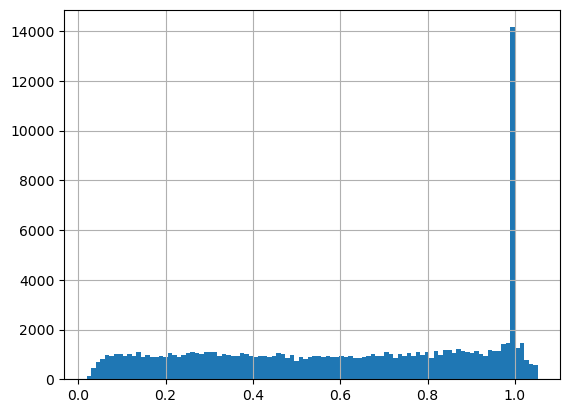

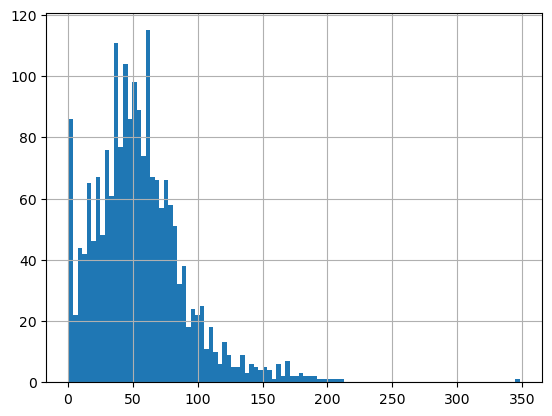

In [ ]:
blast_df = pd.read_csv(blast_output_tsv, sep='\t')
blast_df.columns = ['qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen', 
                    'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore', 'qlen', 'slen']

blast_df = blast_df[blast_df['pident'] > 95]
# Nueva búsqueda recursiva?
# Evitar la obtencion de fragmentos con inserciones
# Búsqueda de fragmentos con deleciones en los extremos, y luego expansión hasta que baje la identidad
# Inlcuir coordenadas con bajas instancias? 

#Block alignment size vs block size
(blast_df['length']/blast_df['qlen']).hist( bins=100)
plt.show()

# Number of aligments for each block
blast_df.groupby('qseqid')['sseqid'].count().hist( bins=100)
plt.show()


In [ ]:
blast_df['']

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,qlen,slen
0,Seq1;size=189,Seq4119;size=1,100.0,114,0,0,1,114,131,18,2.030000e-59,219.0,114,147
1,Seq1;size=189,Seq4013;size=1,100.0,114,0,0,1,114,728,615,2.030000e-59,219.0,114,856
2,Seq1;size=189,Seq3296;size=1,100.0,114,0,0,1,114,240,127,2.030000e-59,219.0,114,241
3,Seq1;size=189,Seq2153;size=1,100.0,114,0,0,1,114,125,12,2.030000e-59,219.0,114,167
4,Seq1;size=189,Seq276;size=11,100.0,114,0,0,1,114,125,12,2.030000e-59,219.0,114,129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166895,Seq6464;size=1,Seq643;size=3,100.0,27,0,0,1,27,29,55,3.850000e-09,52.6,98,55
166896,Seq6464;size=1,Seq622;size=3,100.0,27,0,0,1,27,38,64,3.850000e-09,52.6,98,64
166897,Seq6464;size=1,Seq1003;size=2,100.0,26,0,0,1,26,26,1,1.460000e-08,50.7,98,42
166898,Seq6464;size=1,Seq656;size=3,100.0,26,0,0,1,26,26,1,1.460000e-08,50.7,98,66


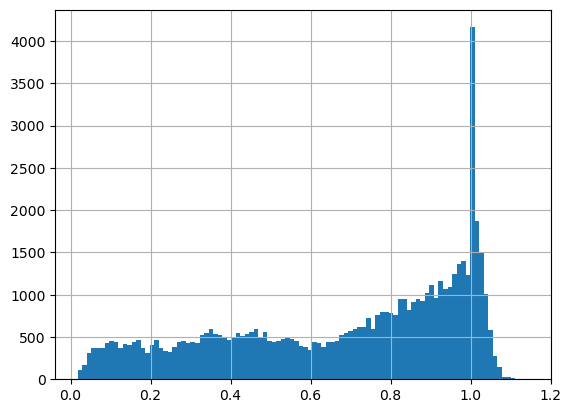

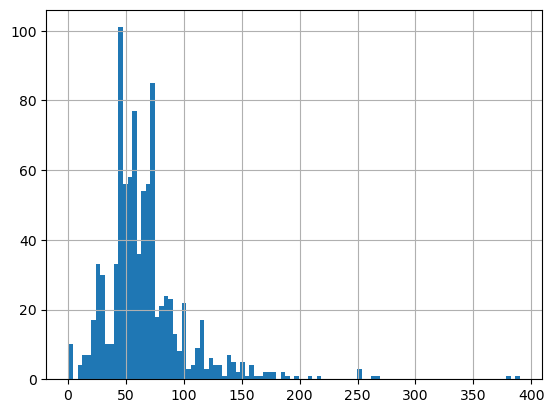

In [ ]:
blast_df = pd.read_csv(blast_output_tsv, sep='\t')
blast_df.columns = ['qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen', 
                    'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore', 'qlen', 'slen']

# Nueva búsqueda recursiva?
# Evitar la obtencion de fragmentos con inserciones
# Búsqueda de fragmentos con deleciones en los extremos, y luego expansión hasta que baje la identidad
# Inlcuir coordenadas con bajas instancias? 

#Block alignment size vs block size
(blast_df['length']/blast_df['qlen']).hist( bins=100)
plt.show()

# Number of aligments for each block
blast_df.groupby('qseqid')['sseqid'].count().hist( bins=100)
plt.show()


In [ ]:
unnoised_df = unnoised_df[unnoised_df['instances'] > 5]
unnoised_df.reset_index().drop(columns='level_1')

KeyError: "['level_1'] not found in axis"

In [ ]:
import seaborn as sns
sns.set_theme(style='whitegrid')


plt.figure(figsize=(24,6))

for coord, height in vars_list[0].items():
    plt.plot(coord, height, '.', color='steelblue')
    plt.text(coord, height, f"{int(height)}", fontsize=8, ha='center', va='bottom')
plt.show()

plt.figure(figsize=(24,6))
for coord, height in vars_list[1].items():
    plt.plot(coord, height, '.', color='steelblue')
    plt.text(coord, height, f"{int(height)}", fontsize=8, ha='center', va='bottom')
plt.show()

/tmp/ipykernel_664779/1216529489.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  seq_df = s3_df.sort_values(['qseqid', 'qstart', 'qend', 'qlen'])[s3_df['qseqid'] == random_seq]


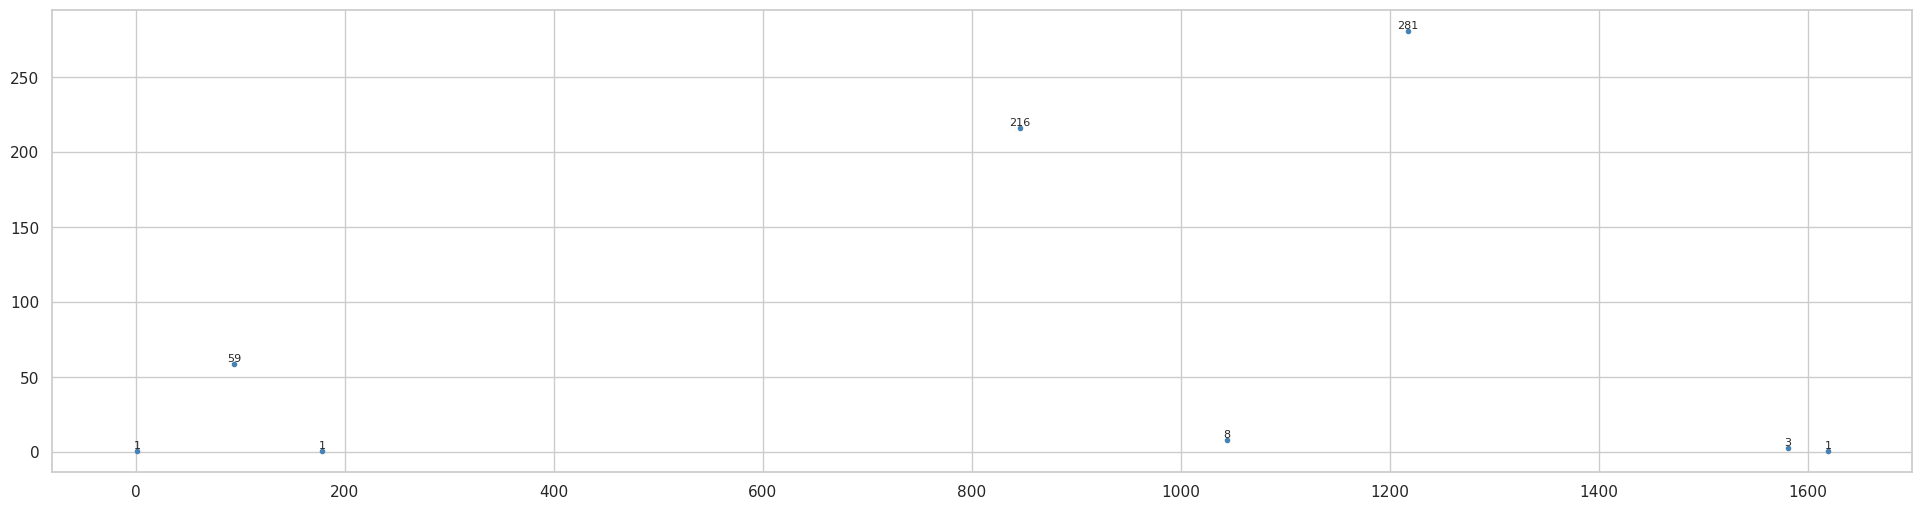

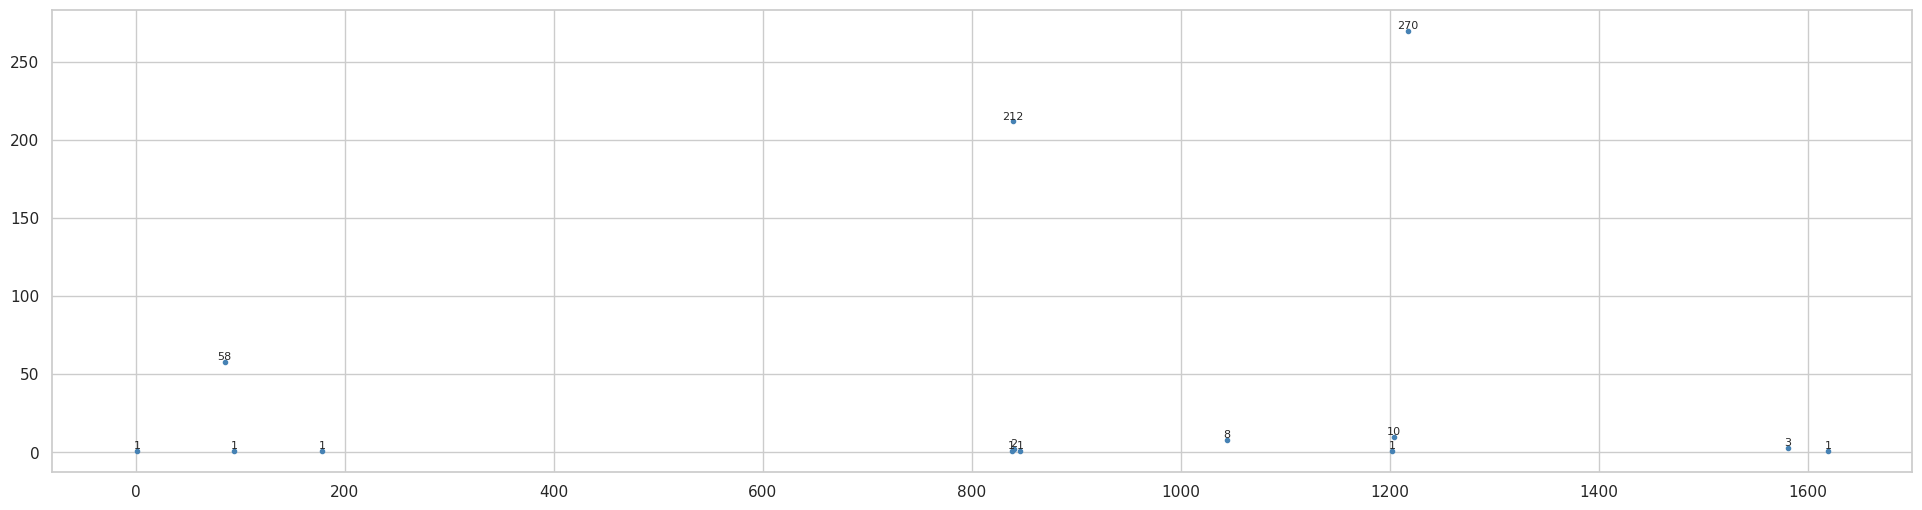

In [ ]:
import numpy as np

random_seq = pd.Series(s3_df['qseqid'].unique()).sample(n=1).iloc[0]
#seq_df = s3_df.sort_values(['qseqid', 'qstart', 'qend', 'qlen'])[s3_df['qseqid'] == 'debde79d-2865-4c3f-82ce-c607a317ea95']
# '0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b' 
# '44ae55cb-7ae8-4b83-bbe7-fa2e58b1b26f'
seq_df = s3_df.sort_values(['qseqid', 'qstart', 'qend', 'qlen'])[s3_df['qseqid'] == random_seq]
#seq_df = s3_df.sort_values(['qseqid', 'qstart', 'qend', 'qlen'])[s3_df['qseqid'] == '44ae55cb-7ae8-4b83-bbe7-fa2e58b1b26f']
def unnoise_coords( df: pd.DataFrame) -> dict: 

    coords = df['qstart'].to_list()
    coords.extend(df['qend'])
    coords.extend([1,df['qlen'].iloc[0]])

    coords_df = pd.DataFrame(data={ 'coords': coords, 'units' : np.ones(len(coords))})
    coords_df = coords_df.groupby('coords').sum().sort_values('units', ascending=False)        
    coords_dict = coords_df['units'].to_dict()

    unnoised_coords = jumping_windows(coords_dict, radius=15)
    return([unnoised_coords, coords_df['units'].to_dict()])

import seaborn as sns
sns.set_theme(style='whitegrid')

#plt.hist(unnoise_coords(seq_df), bins=2631)
vars_list = unnoise_coords(seq_df)
plt.figure(figsize=(24,6))

for coord, height in vars_list[0].items():
    plt.plot(coord, height, '.', color='steelblue')
    plt.text(coord, height, f"{int(height)}", fontsize=8, ha='center', va='bottom')
plt.show()

plt.figure(figsize=(24,6))
for coord, height in vars_list[1].items():
    plt.plot(coord, height, '.', color='steelblue')
    plt.text(coord, height, f"{int(height)}", fontsize=8, ha='center', va='bottom')
plt.show()


In [ ]:
# debde79d-2865-4c3f-82ce-c607a317ea95
# 44ae55cb-7ae8-4b83-bbe7-fa2e58b1b26f
random_seq

'7ecb67c4-6ac1-4fc2-8587-73fa980733ed'

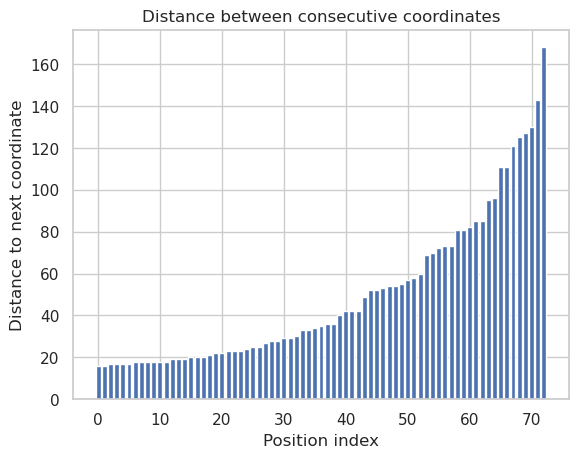

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

coords_list = sorted(list(vars_list[0].keys()))

# Calculate distances between consecutive coordinates
dists = []
for c in range(len(coords_list) - 1):
    dists.append(coords_list[c+1] - coords_list[c])

# Create X-axis values
x_array = np.arange(len(dists))

# Plot
plt.bar(x_array, sorted(dists))
plt.xlabel('Position index')
plt.ylabel('Distance to next coordinate')
plt.title('Distance between consecutive coordinates')
plt.show()


/tmp/ipykernel_664779/857684307.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  seq_df = s3_df.sort_values(['qseqid', 'qstart', 'qend', 'qlen'])[s3_df['qseqid'] == '0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b']


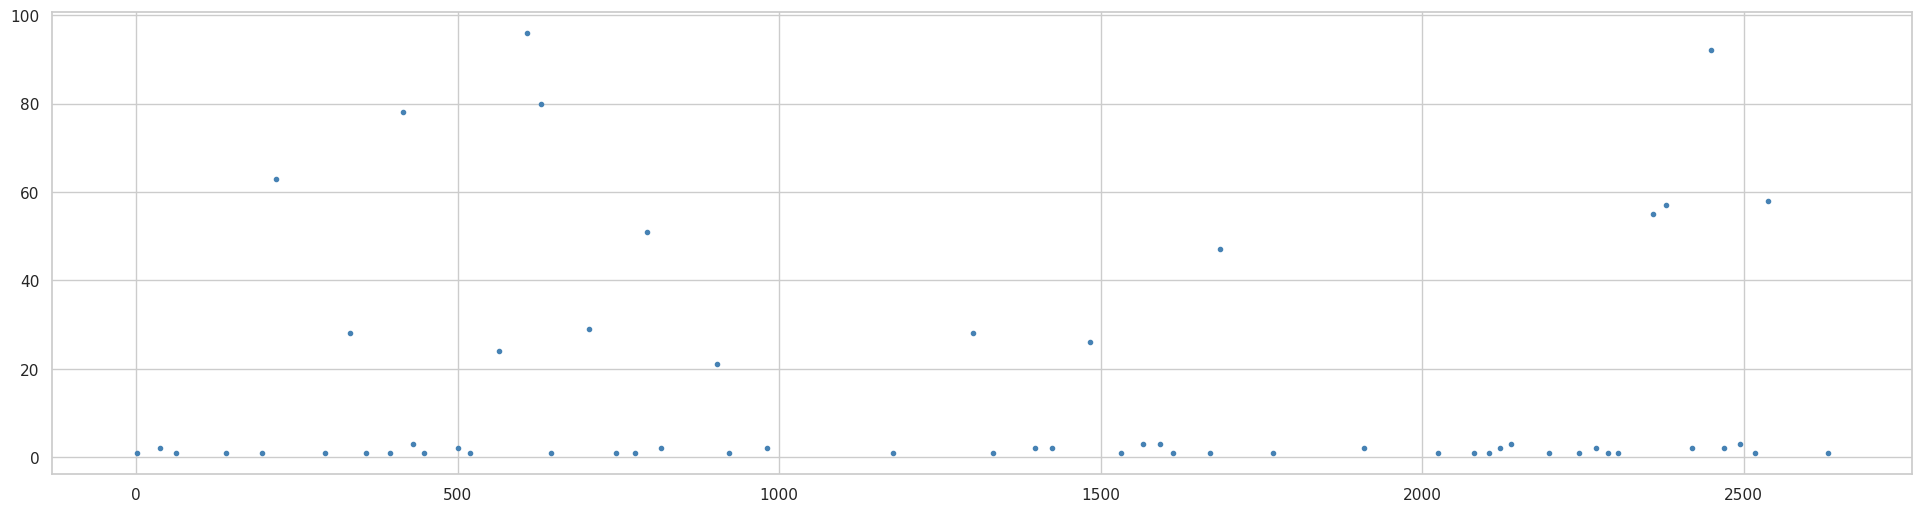

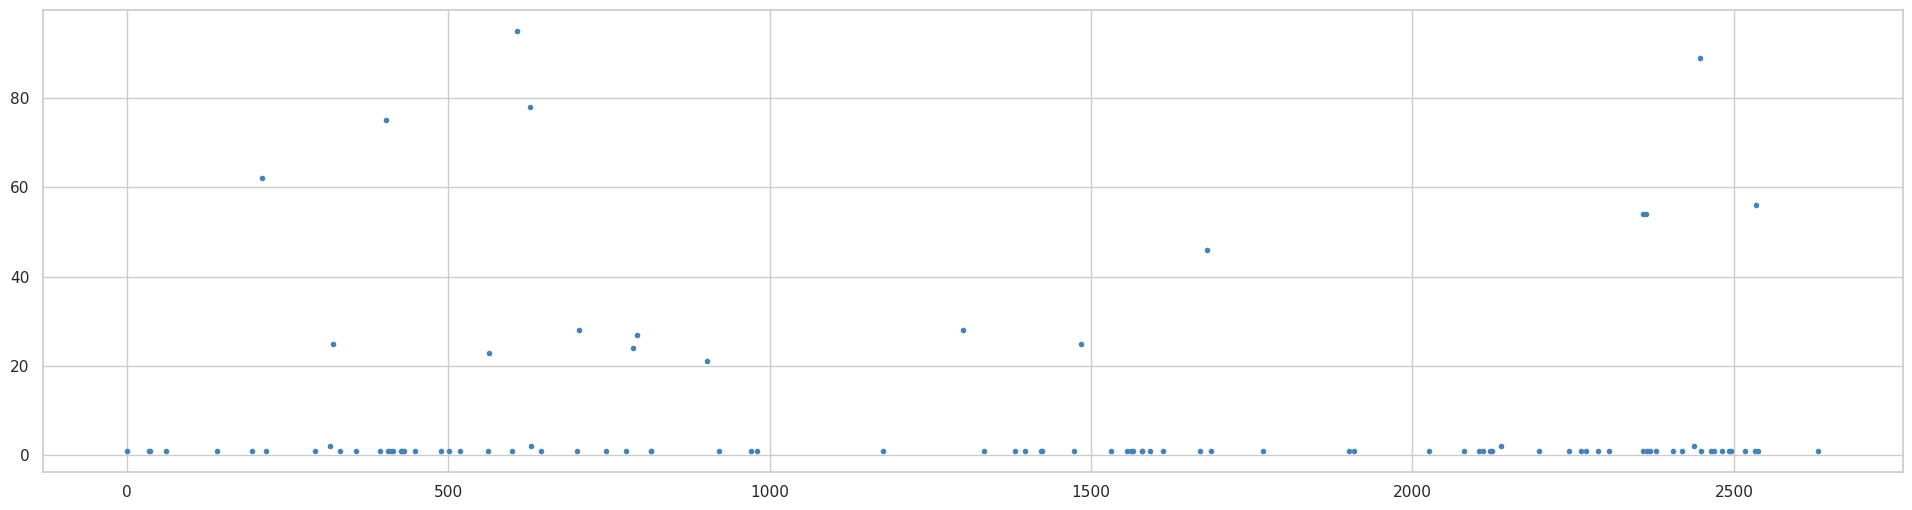

In [ ]:
# debde79d-2865-4c3f-82ce-c607a317ea95

seq_df

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,qlen,slen,a.qstart,a.qend,a.sstart,a.send,dir
60772,debde79d-2865-4c3f-82ce-c607a317ea95,fadfacb2-e251-4149-bc9f-c297168a76b2,99.565,230,1,0,76,305,1638,1409,1.090000e-115,411.0,676,2931,76,305,1409,1638,R
60721,debde79d-2865-4c3f-82ce-c607a317ea95,016a679e-5a8d-446c-9dce-f816174ab6c4,100.000,280,0,0,171,450,43,322,1.840000e-144,506.0,676,7800,171,450,43,322,F
60773,debde79d-2865-4c3f-82ce-c607a317ea95,fc2f9aaf-fef5-4d97-aef4-dd91dc3e343f,100.000,117,0,0,189,305,33,149,5.640000e-56,212.0,676,6231,189,305,33,149,F
60751,debde79d-2865-4c3f-82ce-c607a317ea95,876b184d-6926-49e2-b923-ec9ac9fe70aa,100.000,89,0,0,215,303,737,649,8.950000e-41,161.0,676,834,215,303,649,737,R
60722,debde79d-2865-4c3f-82ce-c607a317ea95,06256e18-2183-46cd-b9b6-e7379f38c079,100.000,91,0,0,215,305,1716,1626,7.350000e-42,165.0,676,6658,215,305,1626,1716,R
60723,debde79d-2865-4c3f-82ce-c607a317ea95,064f8c2f-f02a-4afc-8d67-439a3c1780af,100.000,91,0,0,215,305,2127,2217,7.350000e-42,165.0,676,3273,215,305,2127,2217,F
60724,debde79d-2865-4c3f-82ce-c607a317ea95,09d6f4a1-4c78-4aa5-aa9d-bcbfc0bfeddf,100.000,91,0,0,215,305,3638,3548,7.350000e-42,165.0,676,15231,215,305,3548,3638,R
60725,debde79d-2865-4c3f-82ce-c607a317ea95,1a5b2b54-ac1f-4c23-a8b6-054fbbdecb9e,100.000,91,0,0,215,305,205,295,7.350000e-42,165.0,676,372,215,305,205,295,F
60727,debde79d-2865-4c3f-82ce-c607a317ea95,1f2d5cfc-32c1-4a5c-8bfa-d9e8a7abbc7c,100.000,91,0,0,215,305,1508,1598,7.350000e-42,165.0,676,3809,215,305,1508,1598,F
60728,debde79d-2865-4c3f-82ce-c607a317ea95,215a3b8a-85c4-4ee8-9c1d-b2578589eb2c,100.000,91,0,0,215,305,541,631,7.350000e-42,165.0,676,3817,215,305,541,631,F


/tmp/ipykernel_1390029/857684307.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  seq_df = s3_df.sort_values(['qseqid', 'qstart', 'qend', 'qlen'])[s3_df['qseqid'] == '0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b']


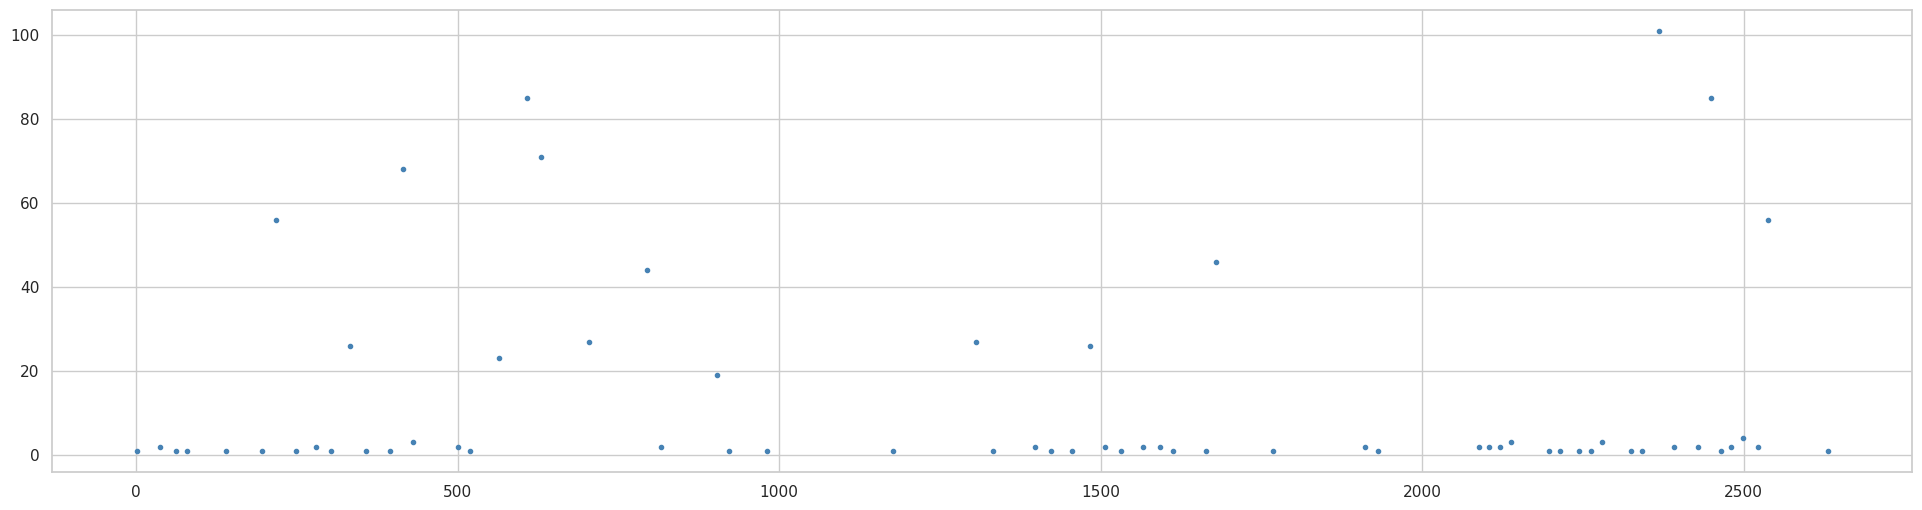

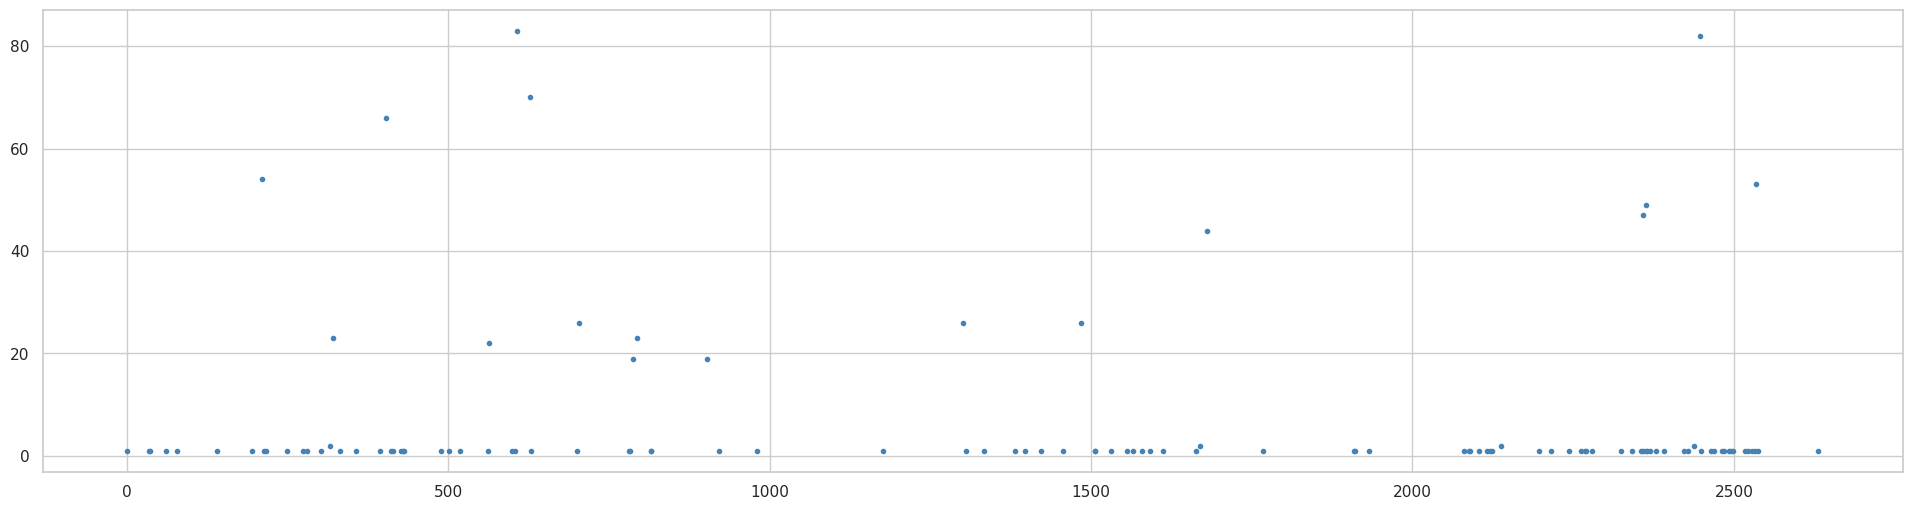

In [ ]:
import numpy as np

seq_df = s3_df.sort_values(['qseqid', 'qstart', 'qend', 'qlen'])[s3_df['qseqid'] == '0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b']
def unnoise_coords( df: pd.DataFrame) -> dict: 

    coords = df['qstart'].to_list()
    coords.extend(df['qend']) 
    coords.extend([1,df['qlen'][0]])

    coords_df = pd.DataFrame(data={ 'coords': coords, 'units' : np.ones(len(coords))})
    coords_df = coords_df.groupby('coords').sum().sort_values('units', ascending=False)        
    coords_dict = coords_df['units'].to_dict()

    unnoised_coords = jumping_windows(coords_dict, radius=15)
    return([unnoised_coords, coords_df['units'].to_dict()])

import seaborn as sns
sns.set_theme(style='whitegrid')

#plt.hist(unnoise_coords(seq_df), bins=2631)
vars_list = unnoise_coords(seq_df)
plt.figure(figsize=(24,6))
for coord, heigth in vars_list[0].items():
    #print(coord, heigth)
    
    plt.plot(coord, heigth, '.', color='steelblue')

plt.show()

plt.figure(figsize=(24,6))
for coord, heigth in vars_list[1].items():
    #print(coord, heigth)
    
    plt.plot(coord, heigth, '.', color='steelblue')
plt.show()


In [ ]:
unnoised_coords

NameError: name 'unnoised_coords' is not defined

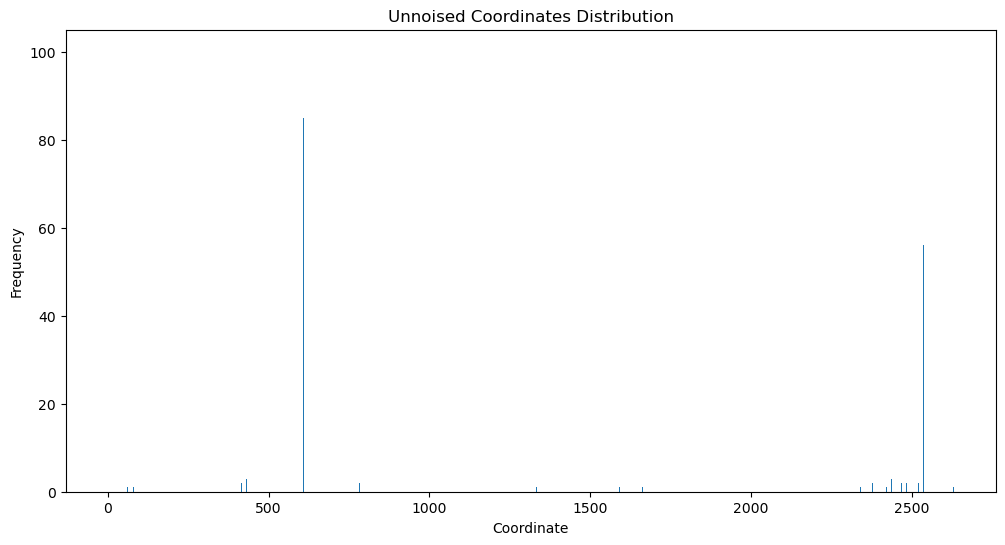

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sort and filter your dataframe
seq_df = s3_df.sort_values(['qseqid', 'qstart', 'qend', 'qlen'])
seq_df = seq_df[seq_df['qseqid'] == '0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b']

def unnoise_coords(df: pd.DataFrame) -> list: 
    coords = df['qstart'].to_list()
    coords.extend(df['qend'].to_list())  # FIX: add .to_list()
    coords.extend([1, df['qlen'].iloc[0]])  # safer to use .iloc[0]

    coords_df = pd.DataFrame(data={'coords': coords, 'units': np.ones(len(coords))})
    coords_df = coords_df.groupby('coords').sum().sort_values('units', ascending=False)        
    coords_dict = coords_df['units'].to_dict()

    unnoised_coords = jumping_windows(coords_dict)
    #unnoised_coords = coords_dict
    
    # Return only the coordinate keys repeated by their counts
    final_coords = []
    for coord, count in unnoised_coords.items():
        final_coords.extend([coord] * int(count))
    
    return final_coords

# Use the function
coords_to_plot = unnoise_coords(seq_df)

# Now plot
plt.figure(figsize=(12, 6))
plt.hist(coords_to_plot, bins=2631)  # You can change bins if you want
plt.xlabel('Coordinate')
plt.ylabel('Frequency')
plt.title('Unnoised Coordinates Distribution')
plt.show()


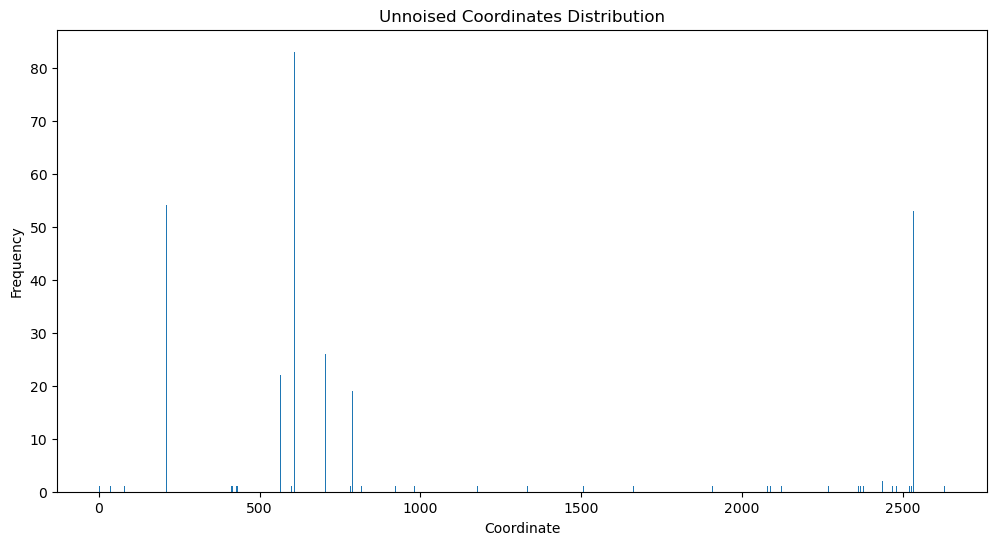

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sort and filter your dataframe
seq_df = s3_df.sort_values(['qseqid', 'qstart', 'qend', 'qlen'])
seq_df = seq_df[seq_df['qseqid'] == '0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b']

def unnoise_coords(df: pd.DataFrame) -> list: 
    coords = df['qstart'].to_list()
    coords.extend(df['qend'].to_list())  # FIX: add .to_list()
    coords.extend([1, df['qlen'].iloc[0]])  # safer to use .iloc[0]

    coords_df = pd.DataFrame(data={'coords': coords, 'units': np.ones(len(coords))})
    coords_df = coords_df.groupby('coords').sum().sort_values('units', ascending=False)        
    coords_dict = coords_df['units'].to_dict()

    unnoised_coords = jumping_windows(coords_dict)
    #unnoised_coords = coords_dict
    
    # Return only the coordinate keys repeated by their counts
    final_coords = []
    for coord, count in unnoised_coords.items():
        final_coords.extend([coord] * int(count))
    
    return final_coords

# Use the function
coords_to_plot = unnoise_coords(seq_df)

# Now plot
plt.figure(figsize=(12, 6))
plt.hist(coords_to_plot, bins=2631)  # You can change bins if you want
plt.xlabel('Coordinate')
plt.ylabel('Frequency')
plt.title('Unnoised Coordinates Distribution')
plt.show()


In [ ]:
coords_list = coords
coords_df = pd.DataFrame(data={ 'coords': coords_list, 'units' : np.ones(len(coords_list))})
coords_df = coords_df.groupby('coords').sum().sort_values('units', ascending=False)        
coords_dict = coords_df.to_dict()

jumping_windows(coords_dict)


Coords Dict: {'units': {608: 83.0, 2448: 82.0, 628: 70.0, 404: 66.0, 210: 54.0, 2534: 53.0, 2364: 49.0, 2358: 47.0, 1680: 44.0, 1301: 26.0, 704: 26.0, 1484: 26.0, 794: 23.0, 321: 23.0, 564: 22.0, 788: 19.0, 903: 19.0, 317: 2.0, 1670: 2.0, 2138: 2.0, 2438: 2.0, 332: 1.0, 357: 1.0, 274: 1.0, 280: 1.0, 217: 1.0, 302: 1.0, 394: 1.0, 501: 1.0, 431: 1.0, 489: 1.0, 430: 1.0, 412: 1.0, 415: 1.0, 427: 1.0, 629: 1.0, 604: 1.0, 562: 1.0, 599: 1.0, 519: 1.0, 782: 1.0, 783: 1.0, 249: 1.0, 79: 1.0, 37: 1.0, 1: 1.0, 35: 1.0, 195: 1.0, 214: 1.0, 140: 1.0, 61: 1.0, 1382: 1.0, 1333: 1.0, 1306: 1.0, 1177: 1.0, 922: 1.0, 981: 1.0, 815: 1.0, 816: 1.0, 700: 1.0, 1556: 1.0, 1565: 1.0, 1531: 1.0, 1506: 1.0, 1507: 1.0, 1422: 1.0, 1397: 1.0, 1768: 1.0, 1909: 1.0, 1932: 1.0, 1911: 1.0, 2088: 1.0, 2089: 1.0, 2104: 1.0, 2080: 1.0, 2116: 1.0, 2121: 1.0, 2123: 1.0, 1580: 1.0, 1612: 1.0, 1592: 1.0, 1663: 1.0, 1456: 1.0, 2269: 1.0, 2262: 1.0, 2244: 1.0, 2215: 1.0, 2197: 1.0, 2355: 1.0, 2342: 1.0, 2270: 1.0, 2363: 1.0,

KeyError: 'units'

In [ ]:
# Make a script to 'substract' alignaments from the same region of a query
# then discard all alingments with a short len
# Also I could make an script that first find the interception between two alignments, and then divide the alignments 
# in that doesn't intercept

def unsuperposed_alignmanets(df: pd.DataFrame) -> pd.DataFrame:
    df = df.sort_values(['qstart', 'qend'])
    qstart = df['qstart']
    qend = df['qend']
    
    new_qstart = []
    new_qend = []
    for i in range(len(qend) - 1):
        if qend[i] > qstart[i+1] and qend[i] < qend[i+1]:
            new_qstart.extend([qstart[i], qstart[i+1], qend[i]])
            new_qend.extend([qstart[i+1], qend[i], qend[i+1]])
            
            
        
        

In [ ]:
sorted_df =  blast_df.sort_values('length')

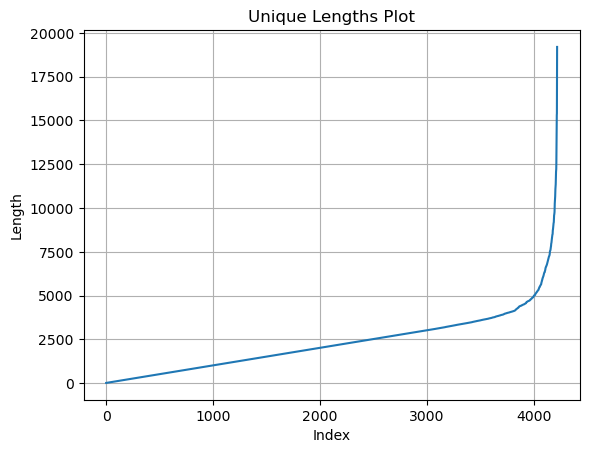

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

lengths = sorted_df['length'].unique()
x_array = np.linspace(1, len(lengths), len(lengths))

plt.plot(x_array, lengths)
plt.xlabel('Index')
plt.ylabel('Length')
plt.title('Unique Lengths Plot')
plt.grid(True)
plt.show()
